In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl as q

In [2]:
#set the API key
q.ApiConfig.api_key ='_Fjzwen5ERibsCY-wTsn'

In [3]:
df = pd.read_csv(r'C:\Users\Administrateur\Downloads\AirPassengers.csv')

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df=df.rename(columns={'#Passengers':'passengers','Month':'date'})
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)
df=df.drop(columns=['date'])
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
from statsmodels.tsa.stattools import adfuller


In [9]:
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


<Axes: xlabel='date'>

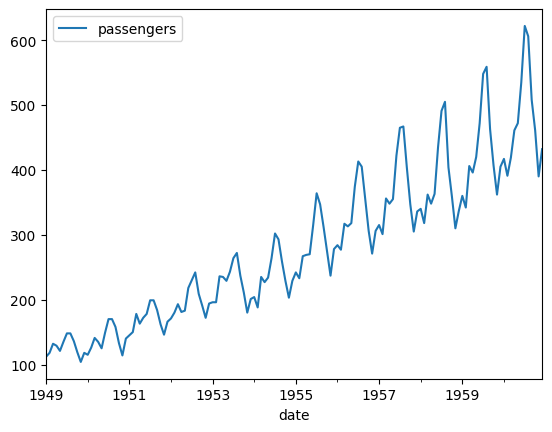

In [10]:
df.plot()

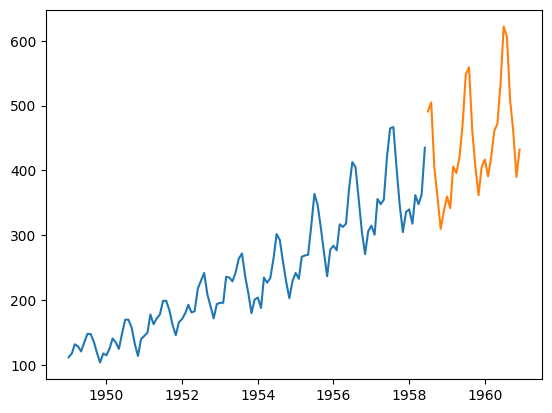

In [11]:
train=df[:114]
test=df[-30:]
plt.plot(train)
plt.plot(test)

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
   
    #Determing rolling statistics
    rolmean = df['passengers'].rolling(window=24).mean() # 24 hours on each day
    rolstd = df['passengers'].rolling(window=24).std()
    

    #Plot rolling statistics:
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [13]:
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


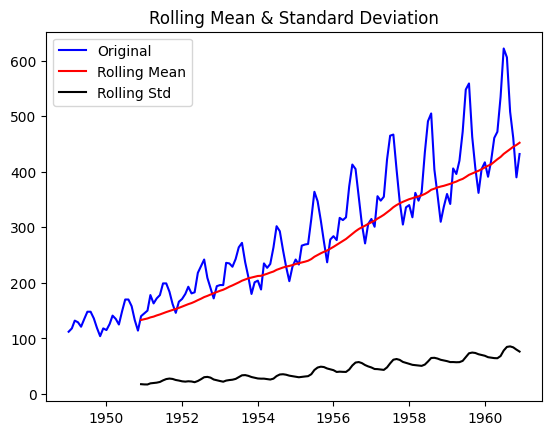

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(df['passengers'])

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

Le test de Dickey-Fuller est utilisé pour tester la présence de racines unitaires dans une série temporelle, ce qui peut indiquer si la série est stationnaire ou non. La sortie du test de Dickey-Fuller comprend plusieurs statistiques et valeurs critiques :

1. Test Statistic (Statistique de test) : Cette valeur représente le résultat du test statistique lui-même. Si la valeur de la statistique de test est inférieure aux valeurs critiques, cela suggère que la série temporelle est stationnaire, c'est-à-dire qu'elle ne possède pas de racines unitaires. Dans cet exemple, la valeur de la statistique de test est 0.815369.

2. p-value (valeur p) : Il s'agit de la probabilité associée à la statistique de test. Elle est utilisée pour évaluer la significativité statistique du test. Si la valeur p est inférieure à un seuil de significativité donné (généralement 0.05), on peut rejeter l'hypothèse nulle selon laquelle la série possède des racines unitaires. Dans cet exemple, la valeur p est 0.991880, ce qui indique que la série n'est pas stationnaire car la valeur p est supérieure au seuil de significativité.

3. #Lags Used (Nombre de retards utilisés) : Cela représente le nombre de retards (lags) inclus dans le modèle lors du test. Dans cet exemple, 13 retards ont été utilisés.

4. Number of Observations Used (Nombre d'observations utilisées) : Cela indique le nombre total d'observations utilisées lors du test. Dans cet exemple, 130 observations ont été utilisées.

5. Critical Values (Valeurs critiques) : Ce sont les seuils ou les valeurs de référence à comparer à la statistique de test pour déterminer la stationnarité. Si la statistique de test est inférieure aux valeurs critiques, cela suggère une stationnarité. Dans cet exemple, trois valeurs critiques sont fournies pour différents niveaux de significativité : 1%, 5% et 10%. Si la statistique de test est inférieure à l'une de ces valeurs critiques, on peut rejeter l'hypothèse nulle de présence de racines unitaires.

En résumé, si la statistique de test est inférieure aux valeurs critiques et si la valeur p est inférieure à un seuil de significativité donné, on peut conclure que la série est stationnaire (absence de racines unitaires). Dans cet exemple, la statistique de test est supérieure aux valeurs critiques, et la valeur p est supérieure au seuil de significativité, indiquant que la série n'est pas stationnaire.

Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

Note: I’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.

Estimating & Eliminating Trend

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

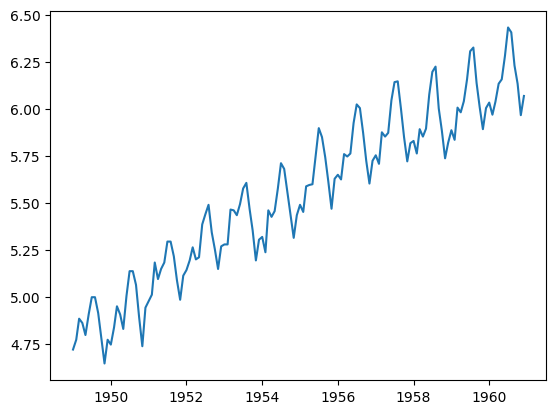

In [15]:
dflog = np.log(df)
plt.plot(dflog)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model
I will discuss smoothing here and you should try other techniques as well which might work out for other problems. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There are can be various ways but I will discuss two of those here.

Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

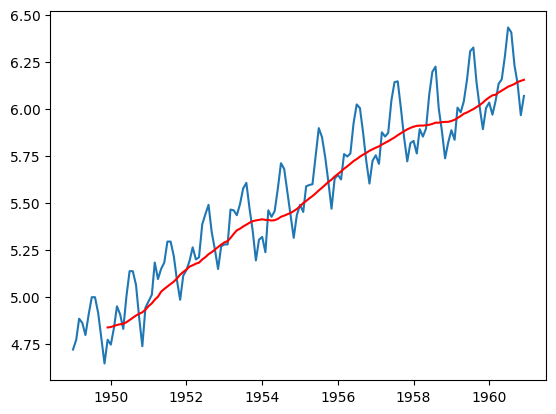

In [16]:
moving_avg = dflog['passengers'].rolling(12).mean()
plt.plot(dflog['passengers'])
plt.plot(moving_avg, color='red')


The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:



In [17]:
log_moving_avg_diff = dflog['passengers'] - moving_avg
log_moving_avg_diff.head(12)

date
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.



In [ ]:
log_moving_avg_diff = log_moving_avg_diff.dropna(inplace=True)
test_stationarity(log_moving_avg_diff)